# Spectral methods for boundary-value problems

## Chebyshev differentiation matrix

Trefethen, *Spectral Methods in MATLAB*, Chap. 6

- Given a function $f$, sample it at Chebyshev points $t_j := \cos \left( \frac{\pi j}{N} \right)$ for $j = 0, \ldots, N$ to get $f_j$.

- Let $p(x)$ be the unique interpolating polynomial of degree $N$ through the points $(t_j, f_j)$.

- Calculate $w_j := p'(t_j)$.

- The map from $\mathbf{f} := (f_j)$ to $\mathbf{w} := (w_j)$ is linear, so given by a matrix $\mathsf{D}$ with $\mathbf{w} = \mathsf{D} \mathbf{f}$. 

- Trefethen gives expressions for the matrix elements of $\mathsf{D}$.

In [61]:
chebyshev_points(N) = [cos(π * j / N) for j in 0:N]   # N+1 points

chebyshev_points (generic function with 1 method)

In [62]:
function chebyshev_differentiation_matrix(N)
    x = chebyshev_points(N)
    c = [2; ones(N-1); 2]

    D = zeros(N+1, N+1)   # want to think of indices 0:N -- use OffsetArray!

    D[1, 1] = (2N^2 + 1) / 6
    D[N+1, N+1] = - D[1, 1]

    for j in 2:N
        D[j, j] = -x[j] / (2*(1 - x[j]^2))
    end

    for i in 1:N+1, j in 1:N+1  # double for loop
        j == i && continue      # syntax for a 1-line "if-then" -- skip i=j

        D[i, j] = (c[i] / c[j]) * (-1)^(i+j) / (x[i] - x[j])
    end

    return D, x
end

chebyshev_differentiation_matrix (generic function with 1 method)

In [63]:
D, x = chebyshev_differentiation_matrix(2);

In [64]:
round.(D, digits=3)

3×3 Array{Float64,2}:
  1.5  -2.0   0.5
  0.5  -0.0  -0.5
 -0.5   2.0  -1.5

## Barycentric Lagrange interpolation

In [65]:
"Weights for Chebyshev barycentric Lagrange interpolation"
w_cheb(j, n) = (-1)^j * ((j==0 || j == n) ? 0.5 : 1.0)

"Evaluate f(x) given samples `fs` at points `ts`. Defaults to Chebyshev weights"
function barycentric_lagrange(x, fs, ts, w=w_cheb)
    n = length(ts) - 1

    numerator = 0.0
    denominator = 0.0

    for j in 0:n

        x == ts[j+1] && return fs[j+1]   # exactly at node
        
        weight = w(j, n) / (x - ts[j+1])

        numerator += (weight * fs[j+1])
        denominator += weight
    end

    return numerator / denominator
end

barycentric_lagrange

## Example: Differentiating an analytic function

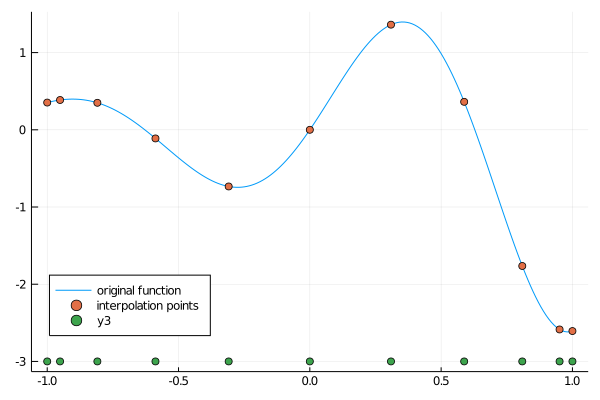

In [70]:
using Plots

N = 10
D, ts = chebyshev_differentiation_matrix(N)

f(x) = exp(x) * sin(5x)
g(x) = exp(x) * 5cos(5x) + exp(x) * sin(5x)


plot(-1:0.01:1, f, label="original function")

fs = f.(ts)

scatter!(ts, fs, label="interpolation points", leg=:bottomleft)
scatter!(ts, fill(-3, length(ts)))

In [72]:
fs = f.(ts)
ws = D * fs;   # using Chebyshev differentiation matrix

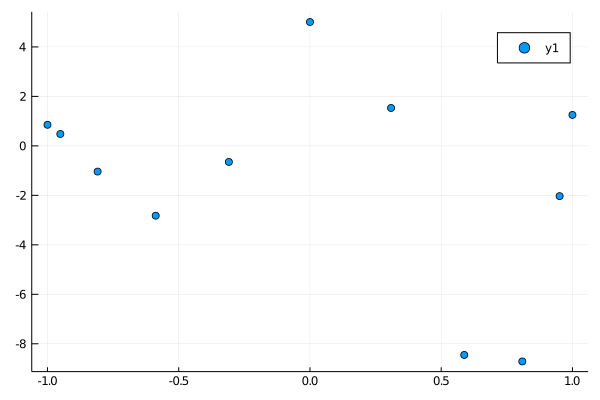

In [73]:
scatter(ts, ws)

These points interpolate the derivative *function* $f'$. We can reconstruct an interpolant of $f'$ using barycentric Lagrange interpolation. We want to sample the function at many points in the interval and compare it to the exact result:

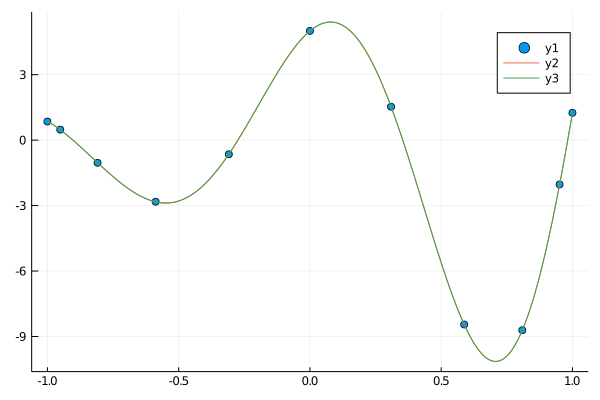

In [74]:
r = -1:0.001:1

scatter(ts, ws)
plot!(r, x -> barycentric_lagrange(x, ws, ts))
plot!(r, g)

We know the analytical result $g$. Let's calculate how far away we are:

In [76]:
Linf_norm(f1, f2) = maximum(abs(f1(x) - f2(x)) for x in -1:0.0001:1)

Linf_norm (generic function with 1 method)

In [77]:
Linf_norm(g, x -> barycentric_lagrange(x, ws, ts))

0.022515571193442052

In [78]:
norms = Float64[]
Ns = 1:100

for N in Ns

    D, ts = chebyshev_differentiation_matrix(N)
    
    fs = f.(ts)
    ws = D * fs;   # using Chebyshev differentiation matrix
    
    push!(norms, Linf_norm(g, x -> barycentric_lagrange(x, ws, ts)))
    
end

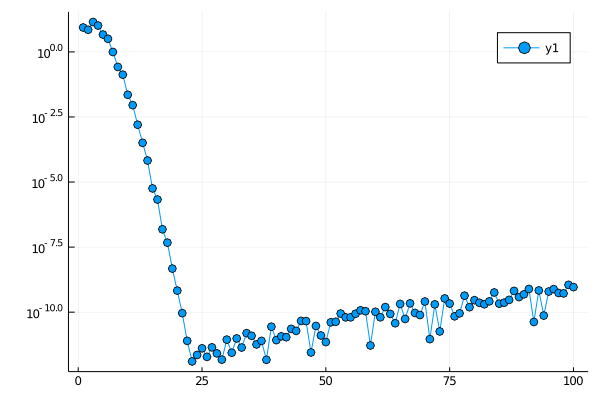

In [79]:
plot(Ns, norms, m=:o, yscale=:log10)

## Boundary-value problem

See Trefethen, Chap. 7

Let's solve

$$u_{xx} = f(x)$$

on $-1 \le x \le 1$, with Dirichlet boundary conditions

$u(-1) = u(+1) = 0$.

When e.g. $f(x) = e^{4x}$ this has a known exact solution, $u(x) = \frac{1}{16} \left[e^{4x} - x \sinh(4) - \cosh(4) \right]$.

In [105]:
N = 1000

D, ts = chebyshev_differentiation_matrix(N)

M = zeros(N + 1, N + 1);

M[2:N, 2:N] = (D^2)[2:N, 2:N];

M[1, 1] = 1
M[N+1, N+1] = 1

f(x) = exp(4x)  # right-hand side

fs = f.(ts)
fs[1] = 0
fs[N+1] = 0

0

Solve $M u = f$

In [106]:
us = M \ fs;

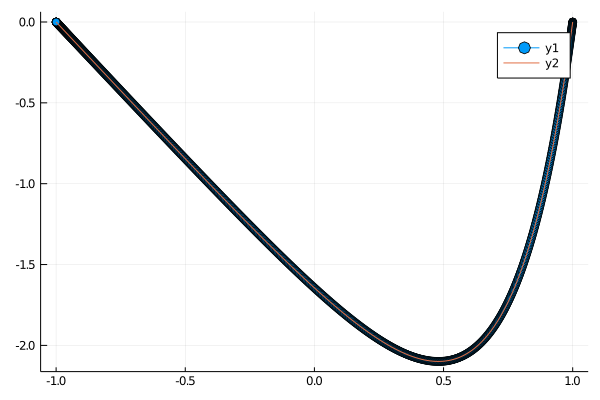

In [107]:
plot(ts, us, m=:o)

plot!(-1:0.01:1, x->(exp(4x) - x*sinh(4) - cosh(4))/16)


## Nonlinear boundary-value problem

Let's solve 
    
$$u_{xx} = \exp(u)$$
    
with $u(-1) = u(+1) = 0$.

Note that the right-hand side is a function *of the unknown function $u$*!

How can we solve this nonlinear equation?

Exercise: Newton

Fixed-point iteration:

Try $u^{n+1}_{xx} = \exp(u^n)$

In [112]:
N = 20

D, ts = chebyshev_differentiation_matrix(N)

M = zeros(N + 1, N + 1);

M[2:N, 2:N] = (D^2)[2:N, 2:N];

M[1, 1] = 1
M[N+1, N+1] = 1

us = zeros(N+1)

f(u) = exp(u)

for i in 1:30
    us = M \ (f.(us))
    us[1] = 0
    us[N+1] = 0
    @show us
end

us = [0.0, -0.012235870926211541, -0.04774575140626314, -0.10305368692688154, -0.17274575140626278, -0.2499999999999991, -0.3272542485937356, -0.3969463130731166, -0.452254248593735, -0.4877641290737862, -0.4999999999999975, -0.48776412907378675, -0.45225424859373625, -0.3969463130731174, -0.32725424859373664, -0.2499999999999999, -0.17274575140626303, -0.10305368692688172, -0.04774575140626313, -0.012235870926211671, 0.0]
us = [0.0, -0.008847746174686942, -0.03429452178314167, -0.07326086394680317, -0.12124109046341779, -0.1730278542431108, -0.22340941033074577, -0.26770779163862524, -0.3021171901909392, -0.3238725161248726, -0.33130911871970864, -0.323872516124873, -0.3021171901909401, -0.26770779163862585, -0.22340941033074652, -0.1730278542431113, -0.12124109046341792, -0.07326086394680327, -0.03429452178314164, -0.00884774617468703, 0.0]
us = [0.0, -0.009805539179417374, -0.03809718274908935, -0.0816841702986443, -0.1358058238838706, -0.19479999263728615, -0.25279027995665415, -0.

us = [0.0, -0.009586112110835411, -0.037225954194179435, -0.07975386725167245, -0.13246646933665904, -0.18980411525432916, -0.24604142880036273, -0.29587052516452, -0.3348286188651388, -0.35957586363573296, -0.3680560244414534, -0.35957586363573324, -0.3348286188651396, -0.29587052516452045, -0.2460414288003634, -0.1898041152543296, -0.13246646933665912, -0.07975386725167255, -0.037225954194179414, -0.009586112110835508, 0.0]
us = [0.0, -0.009586112110834835, -0.03722595419417716, -0.07975386725166742, -0.13246646933665032, -0.18980411525431615, -0.24604142880034519, -0.29587052516449813, -0.3348286188651134, -0.3595758636357053, -0.36805602444142504, -0.35957586363570576, -0.33482861886511434, -0.29587052516449863, -0.2460414288003458, -0.18980411525431654, -0.13246646933665035, -0.07975386725166746, -0.03722595419417711, -0.009586112110834927, 0.0]
us = [0.0, -0.009586112110835003, -0.03722595419417782, -0.07975386725166887, -0.13246646933665285, -0.1898041152543199, -0.2460414288003

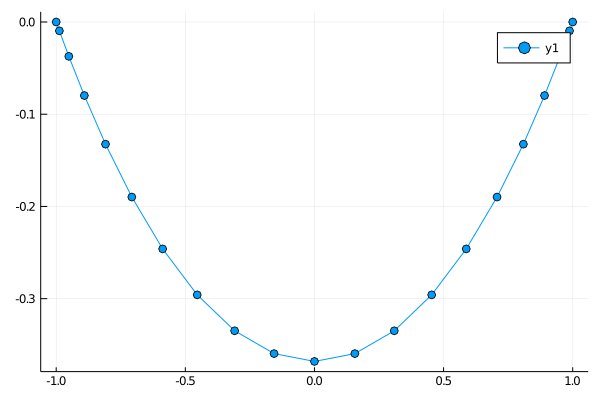

In [113]:
plot(ts, us, m=:o)

In [114]:
M * us - exp.(us)

21-element Array{Float64,1}:
 -1.0
 -6.439293542825908e-15
  1.6653345369377348e-15
 -6.661338147750939e-16
  6.661338147750939e-16
  1.887379141862766e-15
 -6.994405055138486e-15
 -2.886579864025407e-15
 -4.218847493575595e-15
 -1.587618925213974e-14
 -1.0658141036401503e-14
  1.554312234475219e-14
 -3.1086244689504383e-15
  5.773159728050814e-15
 -1.1102230246251565e-16
  3.885780586188048e-15
 -1.1102230246251565e-16
 -7.105427357601002e-15
  9.992007221626409e-15
  1.099120794378905e-14
 -1.0

## Eigenvalue problem

Let's solve

$$u_{xx} = \lambda u$$

with boundary conditions $u(-1) = u(+1) = 0$.

This is an eigenvalue problem *for the differential operator $\partial_{xx}$*!

In [115]:
using LinearAlgebra

In [117]:
λ, v = eigen(M);

In [118]:
λ

21-element Array{Float64,1}:
 -7687.116857081498
 -7631.2836405429625
 -1390.4818293532664
 -1381.7006474694506
  -622.313413817627
  -610.6520817401972
  -396.38089617948856
  -366.88889384285477
  -296.2039916480449
  -246.98689894738573
  -199.8412837348296
  -157.91337267144962
  -120.90268971219018
   -88.82644278107982
   -61.68502747031789
   -39.47841760351854
   -22.206609902451518
    -9.86960440108933
    -2.467401100272377
     1.0
     1.0